## CNN regression

This example demonstrates deep regression on the sample spectral data

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

Enable memory growth for GPU, it is needed on some systems for convolution to work.

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

Dataset, used in this example is unnormalized, while NN requires normalized input. We will perform normalization to the range $[0,1]$ by subtracting minimum value and dividing by maximum.

In [3]:
def norm_func(x, a=0, b=1):
    return ((b - a) * (x - min(x))) / (max(x) - min(x)) + a


def normalize(x, y=None):
    x = np.apply_along_axis(norm_func, axis=1, arr=x)
    mask = ~np.isnan(x).any(axis=1)
    if y is not None:
        return x[mask], y[mask]
    else:
        return x[mask]


Load the dataset, containing surface-enhanced Raman spectra, collected in different laboratories using various methods (https://zenodo.org/record/3572359).

In [4]:
data = pd.read_csv("../ILSdata.csv")

We will use concentration as a target variable. Others are not interesting, so we will drop them.

In [5]:
X = data.drop(['labcode', 'substrate', 'laser', 'method', 'sample', 'type', 'conc',
       'batch', 'replica'], axis=1)
X = X.values
Y = data['conc'].values

Normalize obtained data and split it into training and validation subsets

In [6]:
X, Y = normalize(X, Y)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


Have a look at the normalized spectra. We will not correct background and lean on the convolutional model.

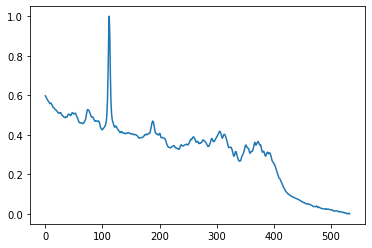

In [7]:
plt.plot(x_train[0])

Define the constants: dimensionality of input data, leaking coefficient for leaky relu activation and dropout probability:

In [8]:
inp_dim = x_train.shape[1]
alpha=0.1
k=0.5


Define convolutional model with leaky relu activation function and batch normalization in between convolutional layers. Last layer uses relu activation, because only positive concentrations are sensible. Data may contain outliers, thus robust Huber loss is used. Since Huber loss may destabilize training, learning rate decay is added to the adam optimizer.

In [9]:
inp = Input(shape=(inp_dim,1))

x = Conv1D(2, 15)(inp)
x = BatchNormalization()(x)
x = LeakyReLU(alpha)(x)
x = MaxPool1D(2)(x)

x = Conv1D(2, 30)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha)(x)

x = Flatten()(x)

x = Dropout(k)(x)
x = Dense(100, activation="linear")(x)
x = LeakyReLU(alpha)(x)

x = Dropout(k)(x)
x = Dense(50, activation="linear")(x)
x = LeakyReLU(alpha)(x)

out = Dense(1, activation="relu")(x)

model = Model(inp, out)
model.compile(loss=tf.keras.losses.Huber(0.3), optimizer=Adam(lr=1e-3, decay=1e-5))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 534, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 520, 2)            32        
_________________________________________________________________
batch_normalization (BatchNo (None, 520, 2)            8         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 520, 2)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 260, 2)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 231, 2)            122       
_________________________________________________________________
batch_normalization_1 (Batch (None, 231, 2)            8     

Add channel dimension to the spectra

In [10]:
x_train  = x_train[:,:,np.newaxis]
x_test  = x_test[:,:,np.newaxis]

And fit the model:

In [11]:
history=model.fit(x_train, y_train, epochs=150, batch_size=32, verbose=1, validation_data=[x_test, y_test])

Train on 2668 samples, validate on 668 samples
Epoch 1/150
2668/2668 [==============================] - 2s 692us/sample - loss: 0.5026 - val_loss: 0.7538
Epoch 2/150
2668/2668 [==============================] - 0s 114us/sample - loss: 0.4342 - val_loss: 0.5623
Epoch 3/150
2668/2668 [==============================] - 0s 109us/sample - loss: 0.4124 - val_loss: 0.5122
Epoch 4/150
2668/2668 [==============================] - 0s 109us/sample - loss: 0.3970 - val_loss: 0.5481
Epoch 5/150
2668/2668 [==============================] - 0s 115us/sample - loss: 0.3836 - val_loss: 0.4898
Epoch 6/150
2668/2668 [==============================] - 0s 109us/sample - loss: 0.3836 - val_loss: 0.4063
Epoch 7/150
2668/2668 [==============================] - 0s 108us/sample - loss: 0.3734 - val_loss: 0.4396
Epoch 8/150
2668/2668 [==============================] - 0s 111us/sample - loss: 0.3738 - val_loss: 0.3917
Epoch 9/150
2668/2668 [==============================] - 0s 108us/sample - loss: 0.3575 - val_los

Plot predicted values over real concentrations and calculate $r^2$ score

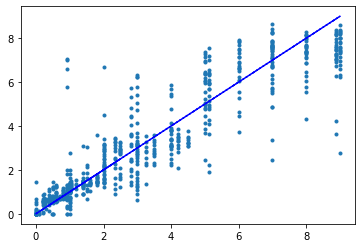

In [12]:
plt.scatter(y_test, model.predict(x_test), marker=".")
plt.plot(y_test, y_test, "--b")

In [13]:
r2_score(y_test, model.predict(x_test))

0.833301352790032

It follows from the picture that model predictions are pretty good for low concentrations of the target, but variance is growing rapidly with increasing concentration, which seems reasonable. Moreover, predictions for high concentrations saturate, which can reflect physical process of surface saturation (see original article).